# SVD Coarsening
* Discretization: 5-point (4th order).
* Fixed-domain problem; repetitive -- sample windows from all over the domain to form the test matrix.

In [1]:
import collections
import logging
import numpy as np
import matplotlib.pyplot as plt
import helmholtz as hm
import pandas as pd
import scipy.sparse
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm, svd
from scipy.sparse.linalg import eigs
from scipy import optimize

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=3, suppress=True, threshold=100000)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

logger = logging.getLogger("main")
_LOGGER = logger

In [7]:
# Fixed seed for reproducible results.
np.random.seed(0)

# Domain size.
n = 96
# Scaled wave number.
kh = 0.5

# Number of test vectors.
num_examples = 20
threshold = 0.1

# Boottstrapping parameters.
threshold = 0.1
interpolation_method = "ls"
num_test_examples = 5

### Relaxation Shrinkage Factor

kh 0
INFO     Iter     |r|                         |x|         RER
INFO     0     1.406e+00                    4.468e-01    3.139
INFO     1     7.628e-01 (0.544) [0.544]    3.342e-01    2.288 (0.728)
INFO     2     4.353e-01 (0.572) [0.558]    2.811e-01    1.561 (0.682)
INFO     3     2.723e-01 (0.627) [0.580]    2.539e-01    1.086 (0.695)
INFO     4     1.864e-01 (0.686) [0.606]    2.380e-01    0.795 (0.732)
INFO     5     1.391e-01 (0.746) [0.632]    2.276e-01    0.622 (0.782)
INFO     6     1.117e-01 (0.803) [0.658]    2.201e-01    0.516 (0.831)
INFO     7     9.389e-02 (0.840) [0.681]    2.144e-01    0.444 (0.863)
INFO     8     8.141e-02 (0.867) [0.702]    2.099e-01    0.393 (0.886)
INFO     9     7.202e-02 (0.884) [0.720]    2.062e-01    0.353 (0.900)
INFO     10    6.475e-02 (0.898) [0.737]    2.030e-01    0.322 (0.912)
INFO     11    5.896e-02 (0.910) [0.751]    2.004e-01    0.296 (0.922)
INFO     12    5.425e-02 (0.919) [0.764]    1.980e-01    0.276 (0.930)
INFO     13    5.0

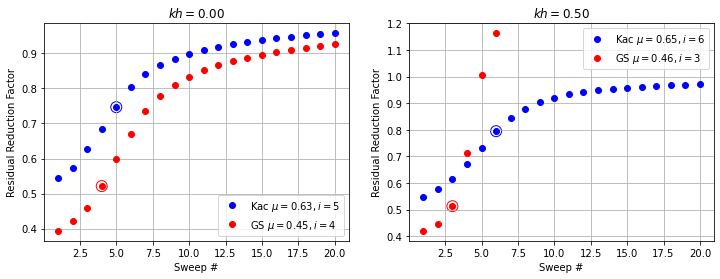

In [8]:
kh_values = [0, 0.5]
fig, axs = plt.subplots(1, len(kh_values), figsize=(12, 4))

kaczmarz = lambda a: hm.solve.relax.KaczmarzRelaxer(a, scipy.sparse.eye(a.shape[0]))
gs = lambda a: hm.solve.relax.GsRelaxer(a)
work = 1

# Kaczmarz.
for kh_value, ax in zip(kh_values, axs):
    print("kh", kh_value)
    a_kh = hm.linalg.helmholtz_1d_5_point_operator(kh_value, n).tocsr()
    operator = lambda x: a_kh.dot(x)

    for title, relax, color in zip(("Kac", "GS"), (kaczmarz, gs), ("blue", "red")):
        method = relax(a_kh)
        factor, num_sweeps, residual, conv, rer, relax_conv_factor = hm.solve.smoothing.shrinkage_factor(
            operator, lambda x, b: method.step(x, b), (a_kh.shape[0], ), 
            print_frequency=1, max_sweeps=20, slow_conv_factor=1.1)
        hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
        print("{:<10s} RER at point of diminishing returns {:.2f} num_sweeps {:>2d} work {:>2d} residual-per-sweep {:.2f}".format(
            title, np.mean(residual[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / rer[0]) ** (1/(num_sweeps * work))))
    
    ax.set_title(r"$kh = {:.2f}$".format(kh_value))
    ax.legend()

The point of diminishing returns in each scatterplot is circled.

This estimate seems to give a reasonable estimate for both $kh$ values and both relaxation schemes (albeit not a quantitative smoothing factor, which can only be defined based on a coarsening), showing that GS is a better smoother for both $kh = 0, 0.5$, but slightly diverges for $kh = 0.5$. The RER at the point of diminishing returns is much smaller.

Averaging over multiple random starts helps reduce noise, as well as assuming a constant reduction per sweep in the initial sweeps (as opposed to a linear model, say). We are only interested in a rough estimate.

In [38]:
def check_coarsening(level, aggregate_size, threshold: float = 0.2):
    """Checks coarsening based on relaxed TVs, for different number of relaxation sweeps.
    If aggregate_size is not None, forces that aggregate size for the entire domain."""
    num_sweeps_values = 5 * 2 ** np.arange(9)

    fig, axs = plt.subplots(len(num_sweeps_values), 3, figsize=(16, 3 * len(num_sweeps_values)))
    for row, num_sweeps in enumerate(num_sweeps_values):
        # Create relaxed TVs.
        x = hm.solve.run.run_iterative_method(
            level.operator, lambda x: level.relax(x, b), x_random, num_sweeps=num_sweeps)[0]

        # Repetitive framework (sample from different windows to form the test matrix).
        x_aggregate_t = np.concatenate(
            tuple(hm.linalg.get_window(x, offset, aggregate_size)
                  for offset in range(max((4 * aggregate_size) // x.shape[1], 1))), axis=1).transpose()
        r, s = hm.setup.coarsening.create_coarsening(x_aggregate_t, threshold)
        r = r.asarray()

        # Relaxed vectors.
        ax = axs[row, 0]
        for i in range(3):
            ax.plot(x[:, i]);
        ax.grid(True)
        ax.set_title(r"Test Vectors, $\nu={}$ sweeps".format(num_sweeps))

        ax = axs[row, 1]
        # R should be real-valued, but cast just in case.
        for i, ri in enumerate(np.real(r)):
            ax.plot(ri)
        ax.set_title(r"Agg Size {} $n_c$ {}".format(r.shape[1], r.shape[0]))
        ax.set_ylabel(r"$R$ rows")
        ax.grid(True);

        # Singular values, normalized to sigma_max = 1.
        ax = axs[row, 2]
        ax.plot(s / s[0], "rx")
        ax.set_title("Singular Values")
        ax.set_xlabel(r"$k$")
        ax.set_ylabel(r"$\sigma_k$")
        ax.grid(True);

        fmt = {'float_kind':lambda x: "%.3f" % x}
        e = (1 - np.cumsum(s ** 2) / sum(s ** 2)) ** 0.5
        _LOGGER.info("nu {:4d} s {} SVD Energy error {}".format(
            num_sweeps, 
            np.array2string(s / s[0], formatter=fmt),  
            np.array2string(e, formatter=fmt)))
        
#         # Generate coarse variables (R) on the non-repetitive domain.
#         result = list(hm.setup.coarsening_uniform.create_coarsening_domain_uniform(x, aggregate_size))
        
#         r, aggregates, nc, energy_error = hm.setup.coarsening.create_coarsening_domain(x, threshold=threshold,
#                                                                                            fixed_aggregate_size=aggregate_size)
#         r_values = np.array([item[0] for item in result])
#         mean_energy_error = np.array([item[1] for item in result])

#         mock_conv_factor = np.array(
#             [hm.setup.auto_setup.mock_cycle_conv_factor(level, r, nu) 
#              for nu in np.arange(1, 5, dtype=int)])
#         _LOGGER.info("Mock cycle conv factor {}".format(np.array2string(mock_conv_factor, precision=3)))

        #     # Coarsening info for different nc values.
    #     info = [(nc, mean_energy_error)
    #             for nc, (r, mean_energy_error) in enumerate(
    #                 hm.setup.coarsening_uniform.create_coarsening_domain_uniform(
    #                     x, aggregate_size, repetitive=True),
    #                 1)]
    #     display(pd.DataFrame(info, columns=("nc", "MEE")))
    #     # Generate coarse variables (R) on the non-repetitive domain.
    #     r, aggregates, nc, energy_error = hm.setup.coarsening.create_coarsening_domain(
    #         x, threshold=threshold, fixed_aggregate_size=aggregate_size)
    #     _LOGGER.info("Agg {}".format(np.array([len(aggregate) for aggregate in aggregates])))
    #     _LOGGER.info("nc  {}".format(nc))
    #     _LOGGER.info("Energy error mean {:.4f} max {:.4f}".format(np.mean(energy_error), np.max(energy_error)))


## Coarsening Quality, Poisson ($kh = 0$)

In [36]:
kh = 0
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()
level = hm.setup.hierarchy.create_finest_level(a)
x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
b = np.zeros_like(x_random)

INFO     nu    5 s [1.000 0.337] SVD Energy error [0.319 0.000]
INFO     nu   10 s [1.000 0.227] SVD Energy error [0.222 0.000]
INFO     nu   20 s [1.000 0.226] SVD Energy error [0.220 0.000]
INFO     nu   40 s [1.000 0.212] SVD Energy error [0.207 0.000]
INFO     nu   80 s [1.000 0.178] SVD Energy error [0.176 0.000]
INFO     nu  160 s [1.000 0.148] SVD Energy error [0.146 0.000]
INFO     nu  320 s [1.000 0.143] SVD Energy error [0.141 0.000]
INFO     nu  640 s [1.000 0.140] SVD Energy error [0.139 0.000]
INFO     nu 1280 s [1.000 0.125] SVD Energy error [0.124 0.000]


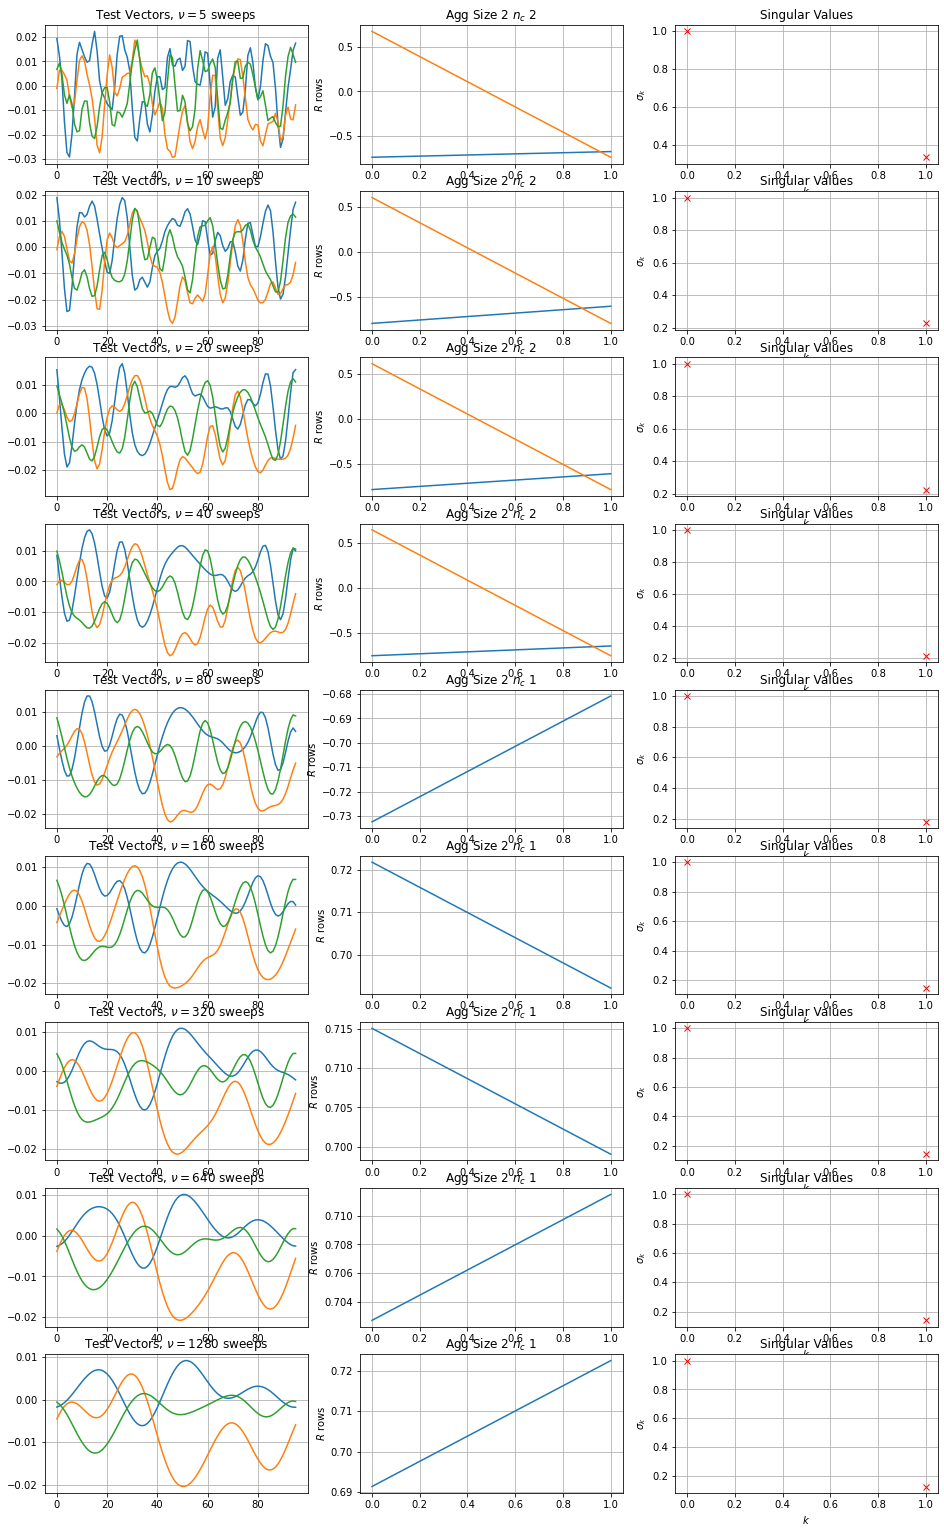

In [39]:
check_coarsening(level, 2)

## Coarsening Quality, Helmholtz ($kh = 0.5$)

In [40]:
kh = 0.5
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()
level = hm.setup.hierarchy.create_finest_level(a)
x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
b = np.zeros_like(x_random)

### Aggregate Size = 3

INFO     nu    5 s [1.000 0.360 0.091] SVD Energy error [0.348 0.086 0.000]
INFO     nu   10 s [1.000 0.320 0.042] SVD Energy error [0.307 0.040 0.000]
INFO     nu   20 s [1.000 0.279 0.029] SVD Energy error [0.270 0.028 0.000]
INFO     nu   40 s [1.000 0.235 0.025] SVD Energy error [0.230 0.024 0.000]
INFO     nu   80 s [1.000 0.189 0.018] SVD Energy error [0.186 0.017 0.000]
INFO     nu  160 s [1.000 0.161 0.012] SVD Energy error [0.159 0.012 0.000]
INFO     nu  320 s [1.000 0.168 0.010] SVD Energy error [0.166 0.010 0.000]
INFO     nu  640 s [1.000 0.225 0.008] SVD Energy error [0.219 0.008 0.000]
INFO     nu 1280 s [1.000 0.314 0.009] SVD Energy error [0.300 0.008 0.000]


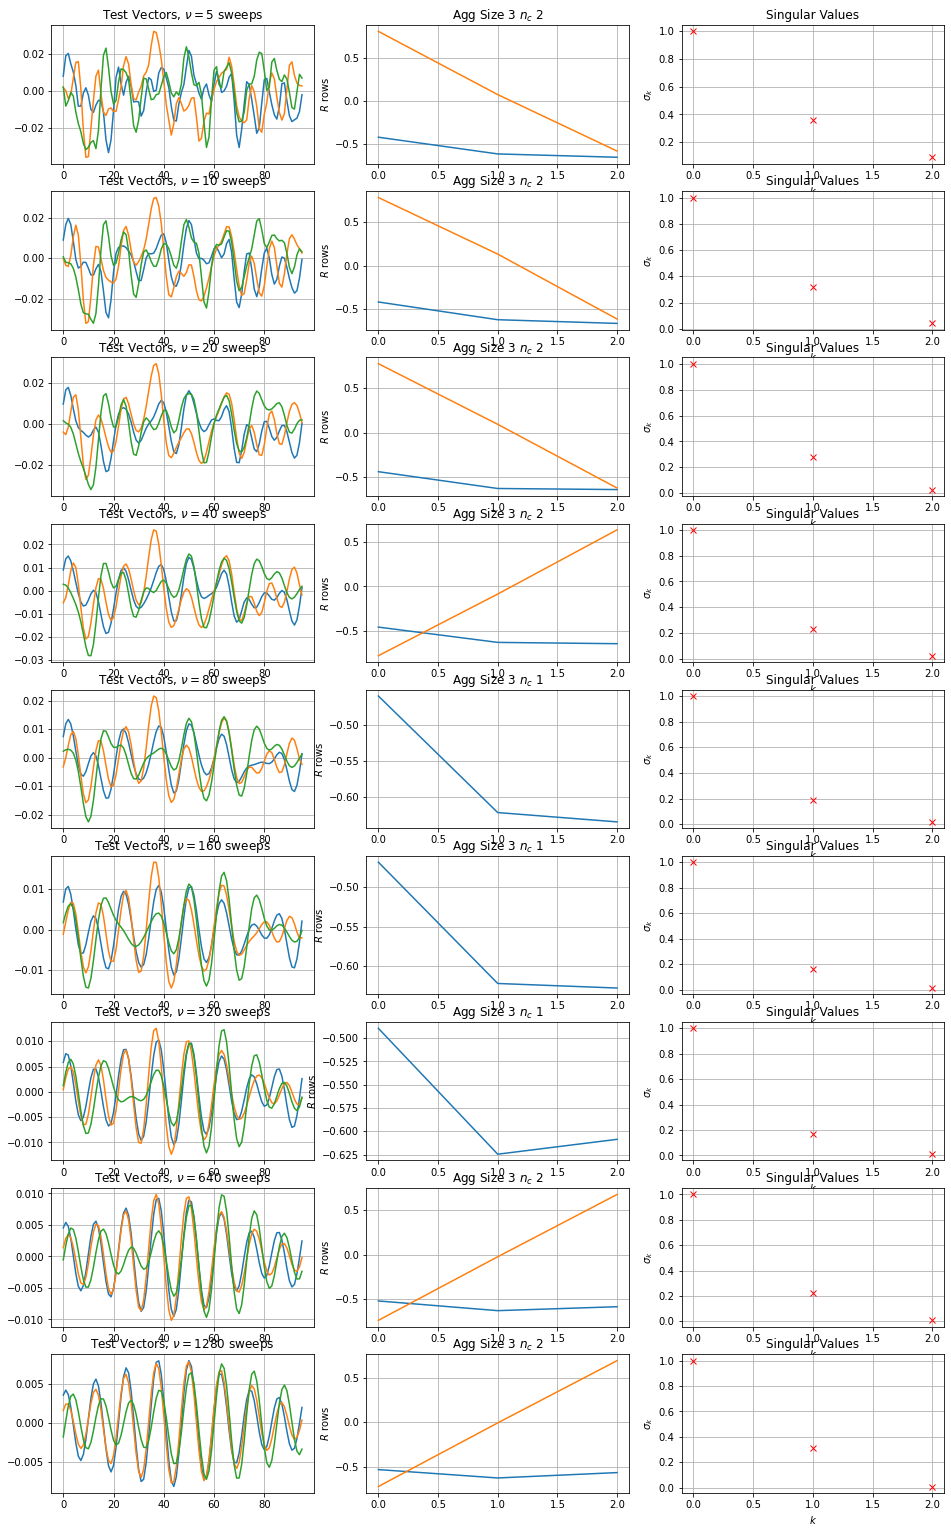

In [41]:
check_coarsening(level, 3)

### Aggregate Size = 6

INFO     nu    5 s [1.000 0.734 0.439 0.209 0.082 0.038] SVD Energy error [0.663 0.370 0.170 0.067 0.028 0.000]
INFO     nu   10 s [1.000 0.728 0.356 0.132 0.020 0.004] SVD Energy error [0.635 0.293 0.103 0.016 0.003 0.000]
INFO     nu   20 s [1.000 0.744 0.281 0.050 0.010 0.002] SVD Energy error [0.624 0.224 0.040 0.008 0.001 0.000]
INFO     nu   40 s [1.000 0.774 0.240 0.019 0.004 0.001] SVD Energy error [0.630 0.187 0.015 0.003 0.001 0.000]
INFO     nu   80 s [1.000 0.807 0.226 0.019 0.002 0.001] SVD Energy error [0.642 0.174 0.015 0.002 0.001 0.000]
INFO     nu  160 s [1.000 0.815 0.198 0.021 0.001 0.001] SVD Energy error [0.643 0.153 0.016 0.001 0.000 0.000]
INFO     nu  320 s [1.000 0.758 0.144 0.020 0.001 0.000] SVD Energy error [0.611 0.115 0.016 0.001 0.000 0.000]
INFO     nu  640 s [1.000 0.770 0.101 0.014 0.000 0.000] SVD Energy error [0.614 0.081 0.011 0.000 0.000 0.000]
INFO     nu 1280 s [1.000 0.812 0.070 0.008 0.000 0.000] SVD Energy error [0.632 0.055 0.006 0.000 0.000

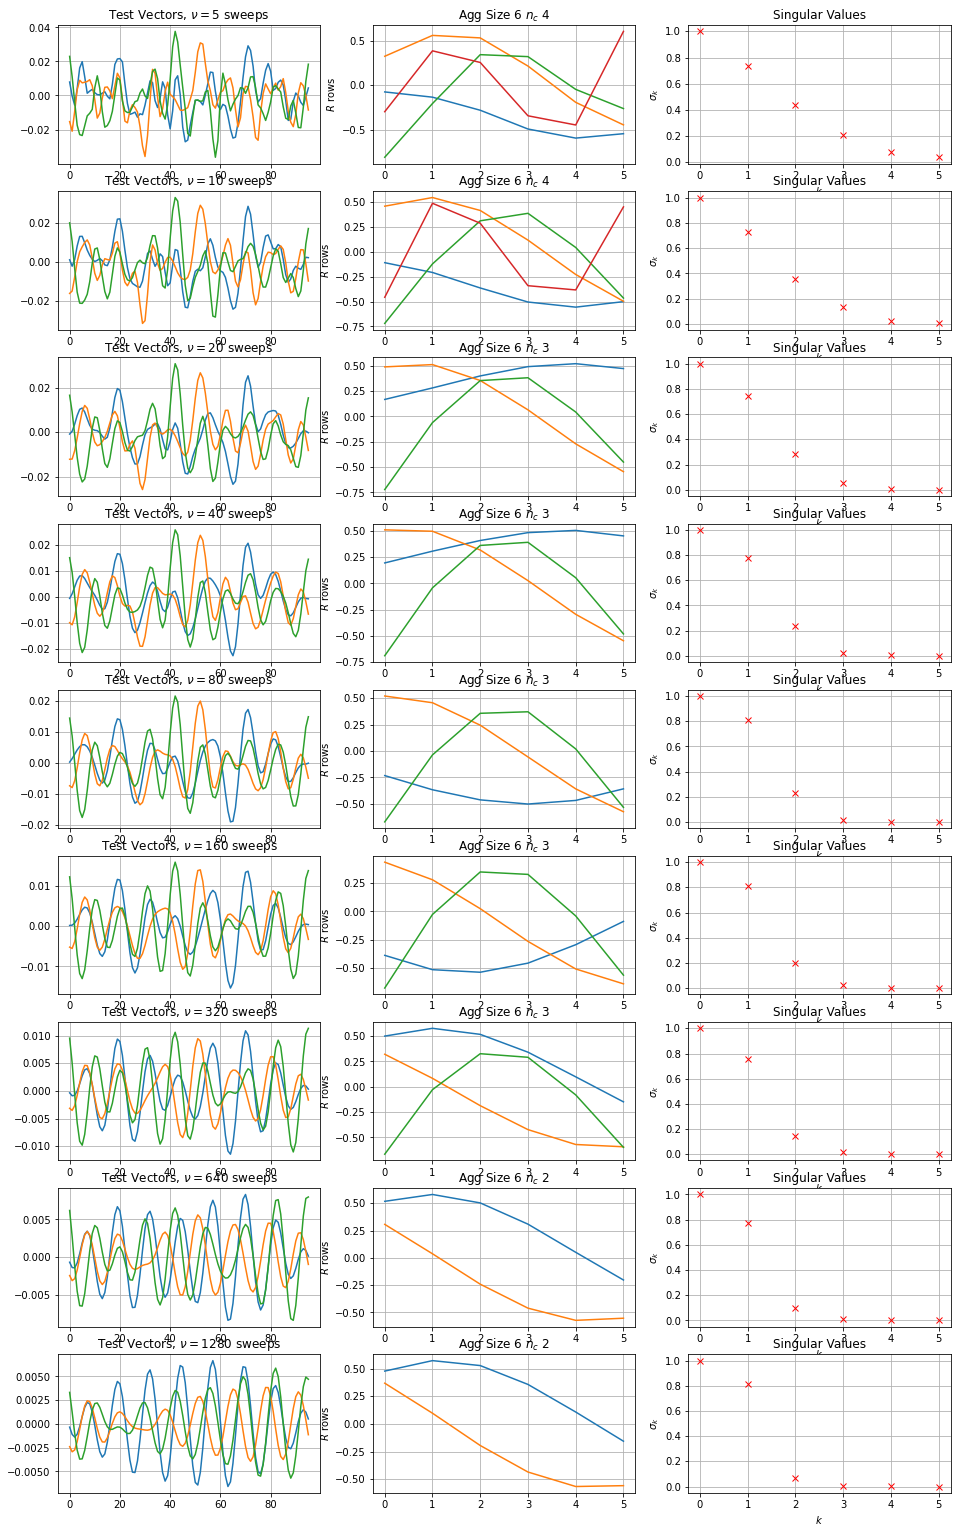

In [33]:
check_coarsening(level, 6)

### Aggregate Size = 8

INFO     nu    5 s [1.000 0.742 0.428 0.345 0.117 0.078 0.047 0.020] SVD Energy error [0.683 0.416 0.275 0.109 0.068 0.038 0.015 0.000]
INFO     nu   10 s [1.000 0.746 0.374 0.178 0.080 0.018 0.006 0.001] SVD Energy error [0.651 0.320 0.149 0.063 0.014 0.004 0.001 0.000]
INFO     nu   20 s [1.000 0.760 0.311 0.097 0.046 0.007 0.002 0.000] SVD Energy error [0.638 0.253 0.083 0.036 0.006 0.001 0.000 0.000]
INFO     nu   40 s [1.000 0.794 0.304 0.081 0.012 0.003 0.001 0.000] SVD Energy error [0.649 0.240 0.062 0.010 0.002 0.001 0.000 0.000]
INFO     nu   80 s [1.000 0.883 0.323 0.079 0.007 0.001 0.001 0.000] SVD Energy error [0.686 0.242 0.058 0.005 0.001 0.001 0.000 0.000]
INFO     nu  160 s [1.000 0.851 0.275 0.077 0.006 0.001 0.000 0.000] SVD Energy error [0.668 0.213 0.058 0.004 0.001 0.000 0.000 0.000]
INFO     nu  320 s [1.000 0.699 0.201 0.064 0.004 0.000 0.000 0.000] SVD Energy error [0.590 0.170 0.052 0.003 0.000 0.000 0.000 0.000]
INFO     nu  640 s [1.000 0.680 0.154 0.041 0.00

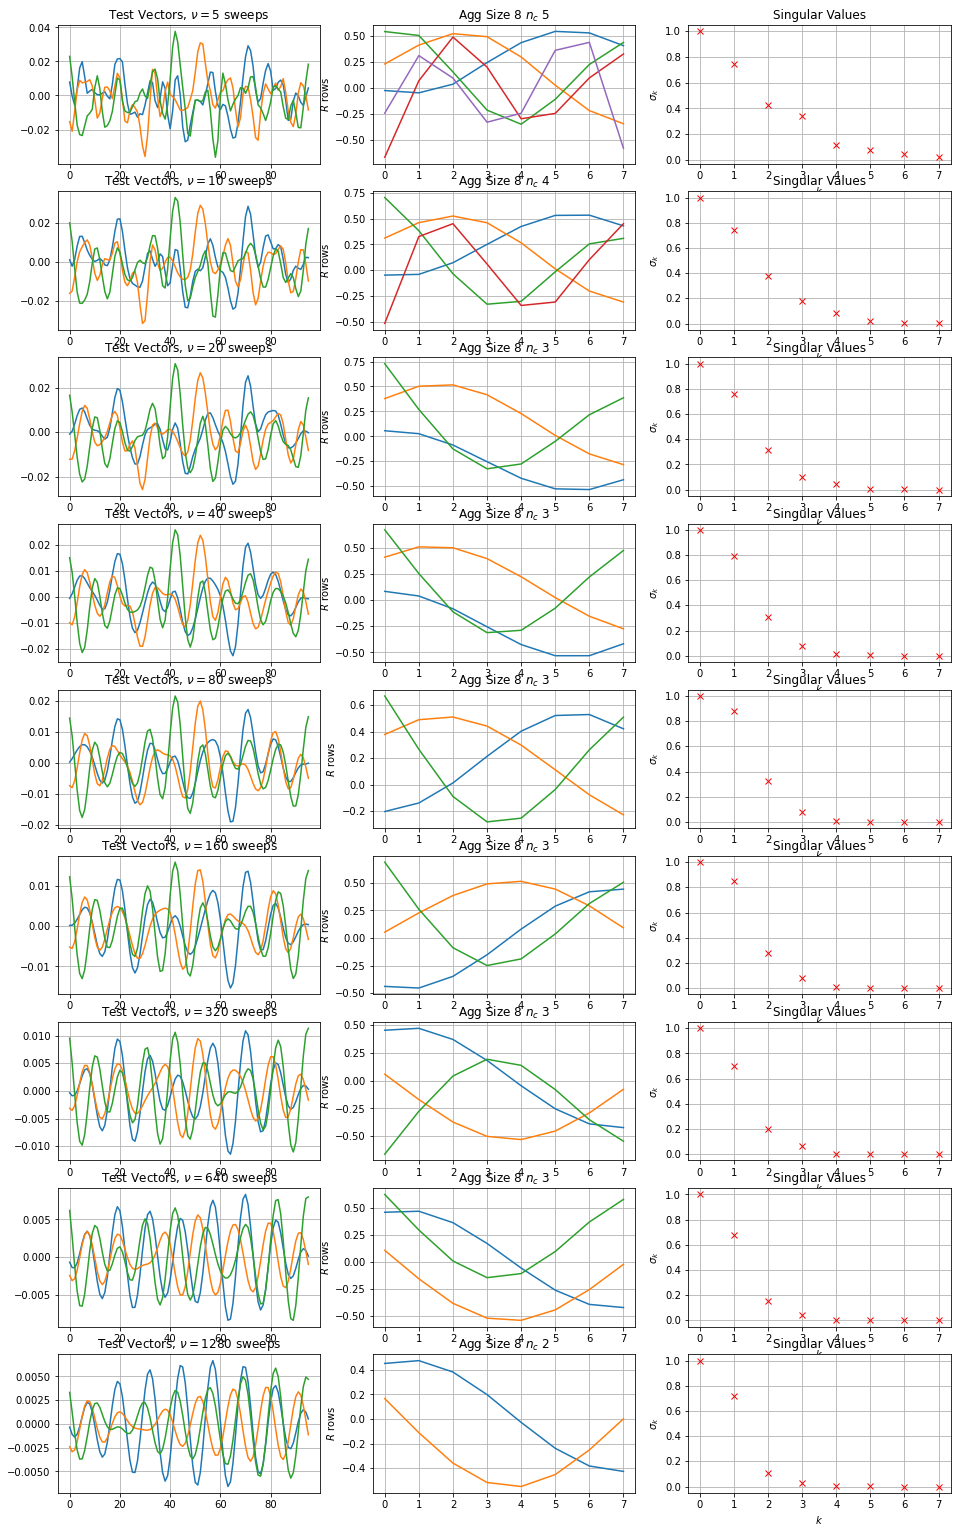

In [34]:
check_coarsening(level, 8)